# Collaboration Analysis

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Introduction**

In this section, our analysis will focus on collaborations. We have essentially two questions:

1. Does collaboration have, on average, a beneficial effect on the number of views, likes, and dislikes?
2. Is there a link between a channel's collaboration rate and its popularity?

For both questions, we will examine the Music and Entertainment categories.

For example, assuming that collaboration has, on average, a beneficial impact on views, likes, and dislikes for both categories, we could compare the magnitude of this benefit between Music and Entertainment. If collaborations in the Music category lead to a significant increase in views and likes compared to those in the Entertainment category, this could indicate that collaborations are particularly effective in attracting and engaging the audience in the musical field. Conversely, if the benefits are more pronounced in the Entertainment category, this could suggest that collaborations there promote more virality and user interaction.

Furthermore, by examining the link between a channel's collaboration rate and its popularity, it would be interesting to determine whether the most popular channels tend to collaborate more frequently. A positive correlation could indicate that collaborations are an effective strategy for increasing visibility and audience. Conversely, the absence of correlation or a negative correlation could suggest that other factors play a more determining role in the popularity of channels.

--- 

**Outline**

**1. Set up and Processing**  
- We will download and process the necessary data files. We will also filter the data to keep only the most viewed videos in both Music and Entertainment categories.

**2. Collaboration Detection: Does Collaboration Have an Overall Beneficial Effect in Terms of Viewership, Number of Likes and Dislikes?**
- We will detect collaborations in both categories and compare the distribution of views, likes and dislikes between collaboration and non-collaboration videos. This will allow us to assess whether collaborations have a beneficial effect on these metrics. 

**3. Analysis of Collaboration Rates and Channel Popularity**
- We will define and compute the collaboration ratio for each channel and analyze its distribution in different contexts. This will help us understand the relationship between a channel's collaboration rate and its popularity.

</div>


## 1. Set up and Processing 

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

Let's start with the necessary imports, we will use $\LaTeX$ for the plots if it is available. 

</div>

In [48]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import src.utils.Collaborations_utils as collab_utils
import src.utils.data_utils as data_utils

# Check if LaTeX is available, if not we don't import the plot_config module
latex_available = False
try:
    plt.rcParams['text.usetex'] = True
    plt.text(0, 0, "Test", fontsize=12)
    latex_available = True
    plt.close()
except Exception as e:
    print("LaTeX is not available. Error:", e)
finally:
    plt.rcParams['text.usetex'] = False

# Import the plot_config module if LaTeX is available
if latex_available:
    pass

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

We can now download the data files and process them. We consider the following files:

**`channels.tsv.gz`**: each row represents an channel and contains the following columns:
- `category_cc`: category of the channel
- `join_date`: join date of the channel
- `channel`: channel id (uniquely defined)
- `name_cc`: name of the channel
- `subscribers_cc`: number of subscribers
- `videos_cc`: number of videos.
- `subscriber_rank_sb`: rank in terms of number of subscribers

**`yt_metadata.jsonl.gz`**: each row represents a video and contains the following columns:
- `categories`: category of the video
- `channel_id`: channel id
- `crawl_date`: date of the crawl
- `description`: description of the video
- `dislike_count`: number of dislikes
- `display_id`: the video id (uniquely defined)
- `duration`: duration of the video
- `like_count`: number of likes
- `tags`: tags of the video
- `title`: title of the video
- `upload_date`: date of the upload
- `view_count`: number of views

</div>

In [2]:
# Download the data files
datasets = [
    # ("https://zenodo.org/records/4650046/files/_raw_df_channels.tsv.gz?download=1", "channels.tsv.gz"), # 6.0 MB
    # ("https://zenodo.org/records/4650046/files/yt_metadata_en.jsonl.gz?download=1", "yt_metadata.jsonl.gz"), # 13.6 GB
]

data_utils.get_data(datasets)

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

We start by filtering the `yt_metadata.jsonl.gz`file to only keep the videos that belong to the Music and Entertainment categories. We then create a new file `yt_metadata_filtered.jsonl.gz` that contains the filtered entries. 

</div>

In [3]:
# Only keep Music and Entertainment Videos
chunk_size = 500_000
# data_utils.process_data(file_path='data/yt_metadata.jsonl.gz',
#                         chunk_size=chunk_size,
#                         preprocess_func=data_utils.filter_categories,
#                         output_path='data/yt_metadata_filtered.jsonl.gz')

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

Now that we have a smaller dataset, we create a new file **`views.jsonl.gz`**. It contains all the entries of the `yt_metadata_filtered.jsonl.gz` dataset. I.e. each entry represents a video, and we only keep columns corresponding to:  
- the video id
- the category
- the number of views

</div>

In [4]:
# process_views(file_path="data/yt_metadata_filtered.jsonl.gz",
#               output_path="data/views.jsonl.gz",
#               chunk_size=chunk_size)

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

This dataset is useful to reduce the size the initial metadata dataset. 

The method is the following: for each category, we only ***keep the most viewed videos that contribute to a fraction $p$ of the total number of views of the category***. To this end, we proceed as follows:
- We sort the videos by the number of views in descending order
- We iterate over the sorted videos and keep adding the views until we reach the fraction $p$ of the total number of views of the category.
- We then keep all the videos that have been added to the selection.

</div>

In [5]:
# Load the views data
df_views = pd.read_json("data/views.jsonl.gz", lines=True, compression="gzip")

category_map = {"Music": 0, "Entertainment": 1}
df_views_music = df_views[df_views["categories"] == category_map["Music"]]
df_views_entertainment = df_views[df_views["categories"] == category_map["Entertainment"]]

In [6]:
# Keep only the top p% of the videos
p = 0.95
df_top_p_music = collab_utils.top_p_views(df_views_music, p)
df_top_p_entertainment = collab_utils.top_p_views(df_views_entertainment, p)

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

We can now print and plot the results of the filtering step.

</div>

Top 95.00% of videos
------------------------------------------------------------------------------
Category        Original Number of Videos      Top Videos           Fraction  
------------------------------------------------------------------------------
Music           8197981                        541108               6.60%     
Entertainment   12015676                       1782414              14.83%    


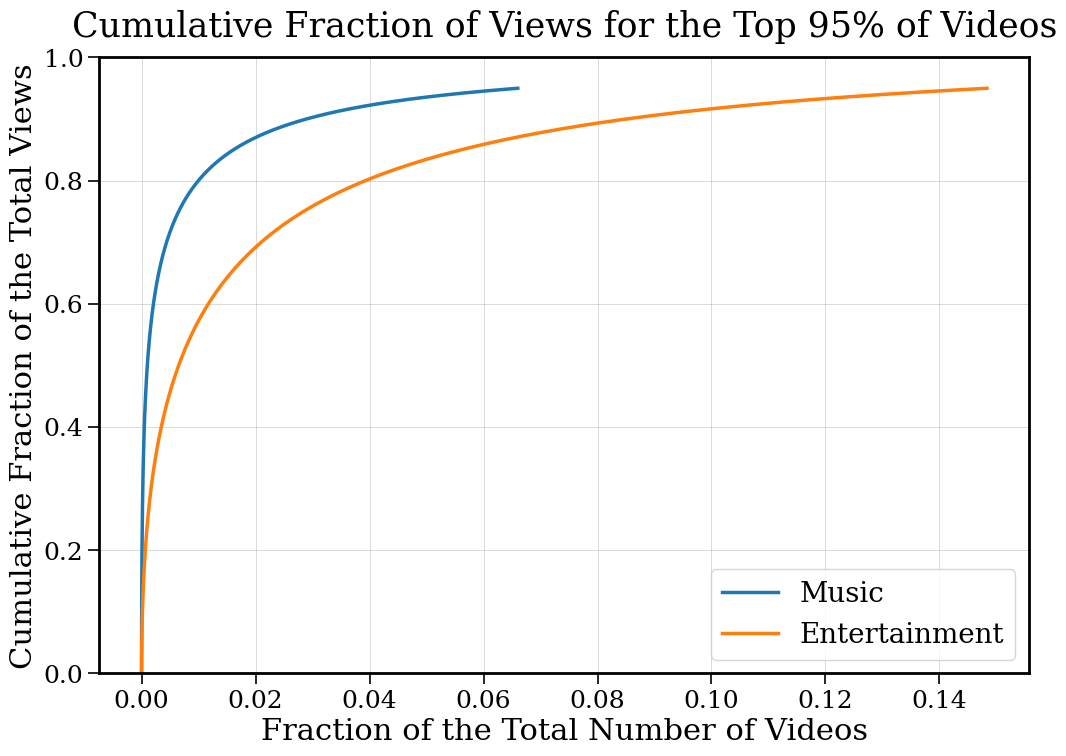

In [7]:
# Print and plot the result of the filtering step
collab_utils.top_p_results(df_views_music, df_top_p_music, df_views_entertainment, df_top_p_entertainment, p, plot=True)

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Comments on the results:** 

The plot illustrates the cumulative fraction of views for the top 95% of videos in the Music and Entertainment categories. It reveals significant differences in view distribution between the two. The $x$-axis represents the fraction of top videos included, while the $y$-axis shows the cumulative proportion of total views. 

- The Music curve rises sharply. This indicates that a small fraction of top music videos (6.60%) captures the majority of total views (95%). 
- The Entertainment curve increases more gradually. It requires more than double the fraction of videos (14.83%) to achieve the same cumulative share of views (95%).

</div>

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

In the following section, the analysis focuses on the dataset composed of the top 95% of videos (as defined above). This choice is motivated by two reasons: one practical, the other methodological. 
- The practical reason is that the filtered dataset is more manageable and allows for faster processing.
- The methodological reason is that this choice makes sense as these videos dominate the platform’s dynamics. They account for the majority of views and represent the most impactful content. 



</div> 

## 2. Collaboration Detection: Does Collaboration Have an Overall Beneficial Effect in Terms of Viewership, Number of Likes and Dislikes? 

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

Here, we focus on the potential benefits of collaborations in terms of viewership, likes, and dislikes. We start by loading the videos that contribute to 95% of the total views in each category. 

**Method**: Each video is given to a function that detects whether it is a collaboration or not. Then, within a category, we compare the distribution of views, likes, and dislikes between collaboration and non collaboration. With this analysis, we aim to determine whether collaborations have a beneficial effect on these metrics. We perform statistical tests to assess the significance of the differences observed.

</div>

### Collaboration Detection using Video Titles

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

Each video is labelled via a binary variable indicating whether it is a collaboration or not. We use a really simple model of collaboration detection which is based on keywords. By default, the keywords are: `feat`, `ft`, `ft.`, `featuring`, `x` and `w/`. These can be specified in the `collab_utils.detect_collaboration` function. While processing the data, many combinations of keywords were attempted `&`, `with`, `+`... but this yielded many false positives. We thus made the choice to be a bit conservative in the detection. Another approach using a pretrained language model ([facebook/bart-large-mnli](https://huggingface.co/facebook/bart-large-mnli)) was attempted with various prompting techniques but the results were not satisfactory as there were too many false positives and negatives.

</div>

In [3]:
# Load the data
top_p_music = pd.read_json("data/top_95.0_Music.jsonl.gz", lines=True, compression="gzip")

In [4]:
top_p_entertainment = pd.read_json("data/top_95.0_Entertainment.jsonl.gz", lines=True, compression="gzip")

In [5]:
# Detect collaborations and sort the data by the number of views
top_p_music["collab"] = top_p_music["title"].apply(lambda x: collab_utils.detect_collaboration(x))
top_p_entertainment["collab"] = top_p_entertainment["title"].apply(lambda x: collab_utils.detect_collaboration(x))

top_p_entertainment = top_p_entertainment.sort_values(by="view_count", ascending=False)
top_p_music = top_p_music.sort_values(by="view_count", ascending=False)

In [6]:
collab_utils.print_collab_stats(top_p_music, top_p_entertainment)

Category                       Number of Videos     Number of Collaborations       Fraction            
-------------------------------------------------------------------------------------------------------
Music                          541108               67893                          12.55%              
Entertainment                  1782414              46357                          2.60%               


### Comparison of the distribution of Views, Likes and Dislikes across Collaborations and Non-collaborations

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">    

For each category, we will plot the following types of distributions:
- Histograms: these allow us to observe the overall shape and spread of the data in each group.
- Boxplots: help us summarize and compare the central tendency and variability between the two groups
- Complementary Cumulative Distrbution Functions (CCDFs): enable us to analyze the probability of observing values above a certain threshold

This will allow us to visually compare the distributions of views, likes, and dislikes between collaboration and non-collaboration videos.

</div>


#### Music Category

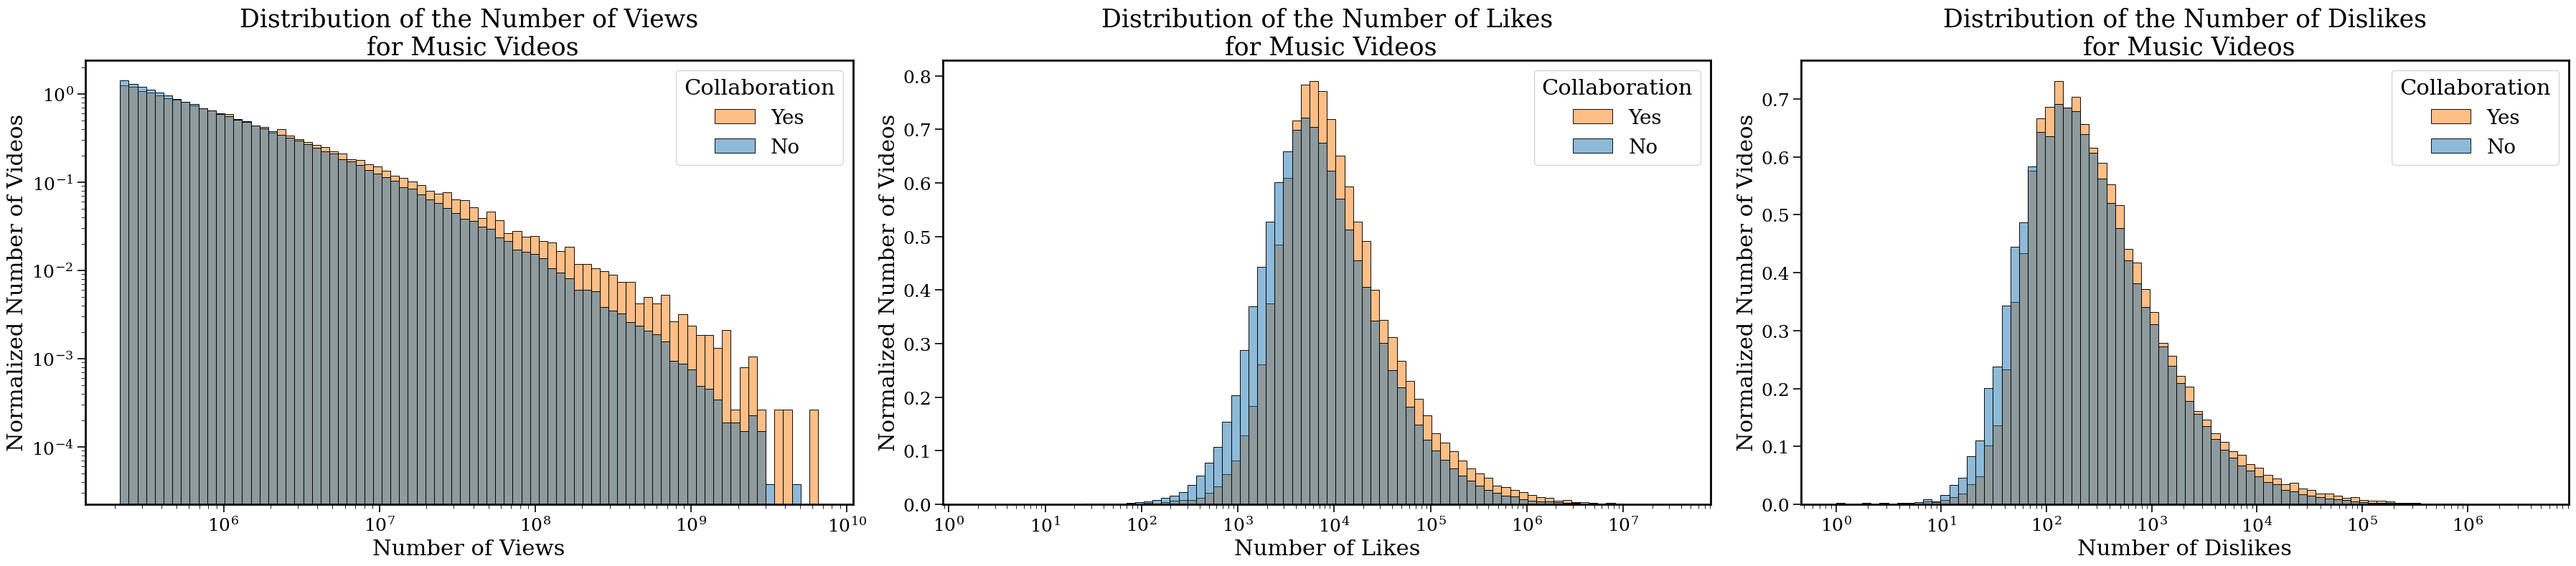

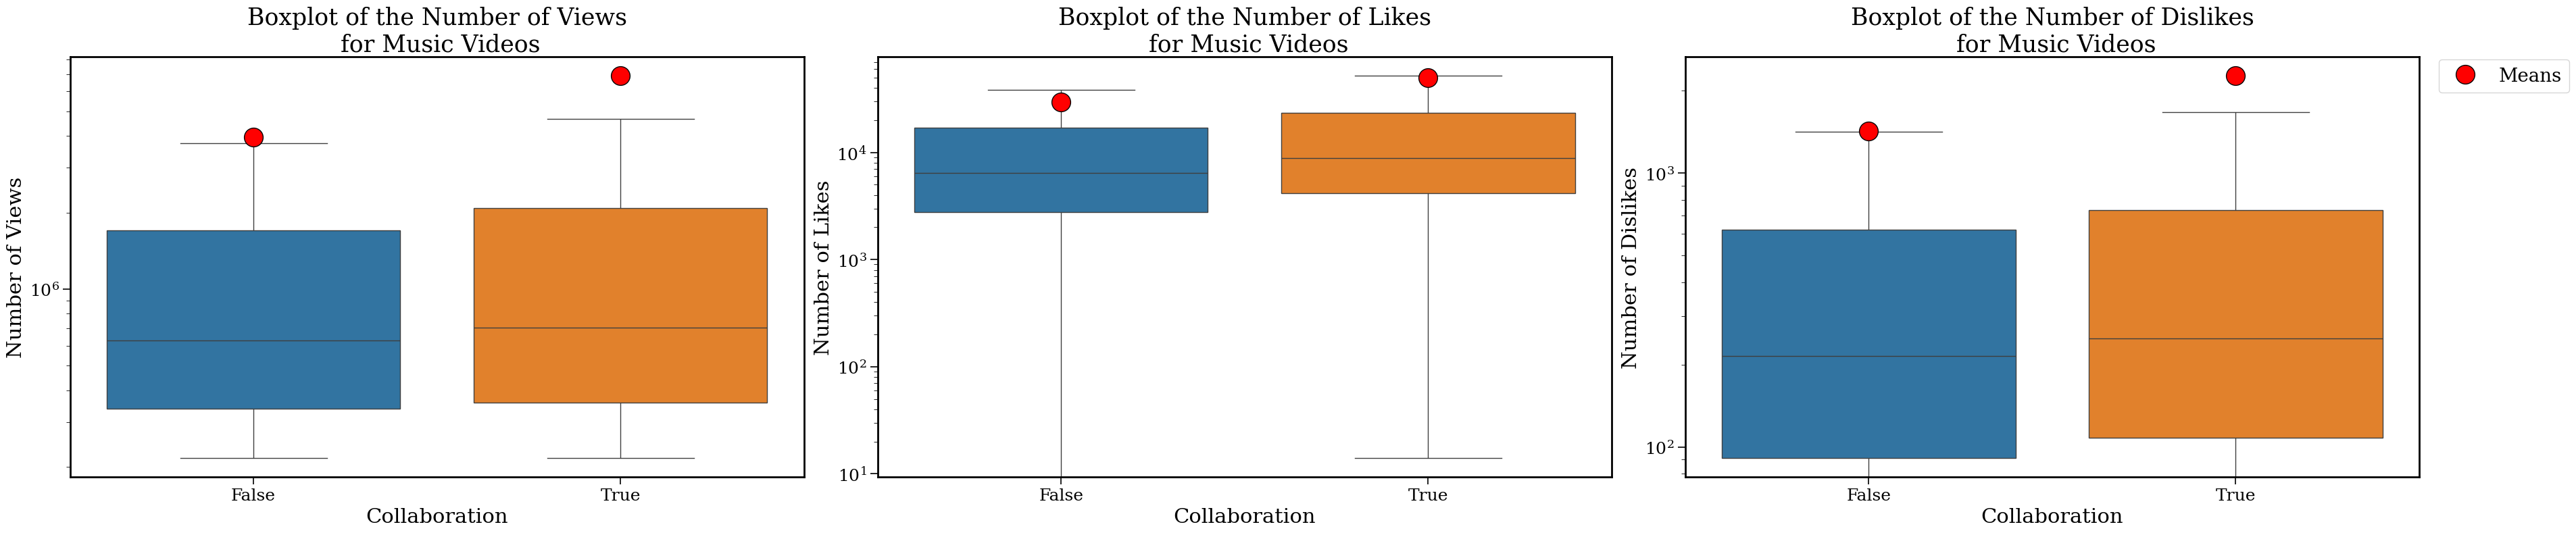

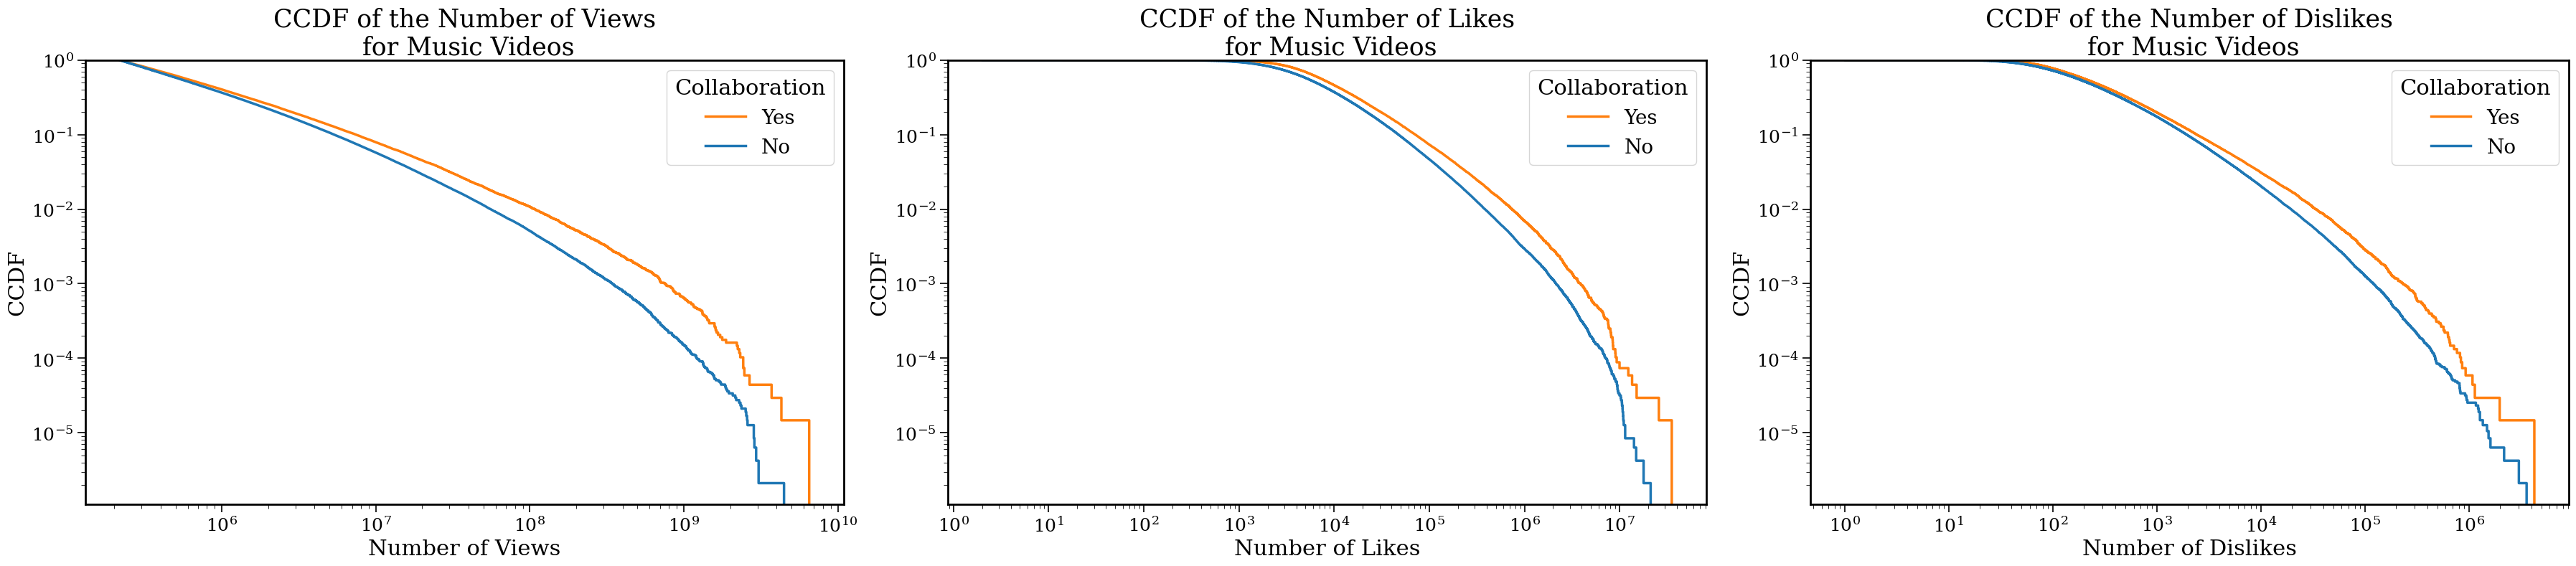

In [7]:
# Compare the different distributions between collaborations and non collaborations for the Music category
columns = ["view_count", "like_count", "dislike_count"]
custom_labels = {"view_count": "Number of Views", "like_count": "Number of Likes",
                 "dislike_count": "Number of Dislikes"}
x_logs = [True, True, True]
y_logs = [True, False, False]

collab_utils.plot_comparison_collab_and_non_collab(
    data=top_p_music,
    category="Music",
    columns=columns,
    x_logs=x_logs,
    y_logs=y_logs,
    custom_labels=custom_labels,
    save=True,
)

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Comments on the Figures:**

From left to right, the plots compare the distributions of views, likes, and dislikes between collaboration and non-collaboration videos in the Music category.

- **Views**: from the histogram, we observe that the tail of the distribution is heavier for collaborations. This indicates that collaborations tend to have a higher number of views compared to non-collaboration videos. This is confirmed by the boxplot and CCDF, which show that the median and the upper percentiles are higher for collaborations. On the boxplot, the mean is also depicted by a red dot for each category. Clearly, the mean is higher for collaborations. 

- **Likes**: For both collaboration and non collaboration, the distributions seem to be close to log-normal. But a noticeable difference is that for collaborations, the histogram is slightly shifted toward higher like counts. This is confirmed by the boxplot and CCDF, which show that the median and the upper percentiles are higher for collaborations. The mean is also higher for collaborations.

- **Dislikes**: A similar analysis can be made for dislikes. 
</div>

In [8]:
collab_utils.compare_means_collab_non_collab(top_p_music, columns, custom_labels)

╒═════════════════════════╤══════════════════╤══════════════════════╤════════════════╕
│ Metric                  │ Collaborations   │ Non-Collaborations   │   Ratio (C/NC) │
╞═════════════════════════╪══════════════════╪══════════════════════╪════════════════╡
│ Mean Number of Views    │ 6,901,665.40     │ 3,963,053.55         │           1.74 │
├─────────────────────────┼──────────────────┼──────────────────────┼────────────────┤
│ Mean Number of Likes    │ 49,664.34        │ 29,515.81            │           1.68 │
├─────────────────────────┼──────────────────┼──────────────────────┼────────────────┤
│ Mean Number of Dislikes │ 2,271.68         │ 1,423.92             │           1.6  │
╘═════════════════════════╧══════════════════╧══════════════════════╧════════════════╛


<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Comment on the table:** 

The table shows the mean values for views, likes, and dislikes for collaboration and non-collaboration videos in the Music category. It also displays the ratio between the two means. As observed in the figures, collaborations tend to have higher mean values for all metrics by a factor ranging between $1.6$ and $1.74$.

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

Three statistical tests are performed to assess the significance of the difference between the distributions for collaboration and non collaboration videos: 
- *Kolmogorov-Smirnov test*: this test compares the cumulative distribution functions of the two samples. It is a non-parametric test that does not assume any specific distribution for the data.
- *Mann-Whitney U test*: this test is also non-parametric and compares the medians of the two samples. It is used when the data is not normally distributed.
- *Cramér-von Mises test*: this test is similar to the Kolmogorov-Smirnov test (it is based on the cumulative squared differences between their empirical distribution functions) but is more sensitive to differences in the tails of the distribution.

In [9]:
collab_utils.test_distributions(top_p_music, columns, custom_labels)

╒═════════════════════════════════════════╤═════════════╤═══════════╤════════════════╕
│ Test                                    │   Statistic │   P-Value │ Significant?   │
╞═════════════════════════════════════════╪═════════════╪═══════════╪════════════════╡
│ Mann-Whitney U (Number of Views)        │    1.7e+10  │ 1.06e-122 │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Kolmogorov-Smirnov (Number of Views)    │    0.0388   │ 5.36e-78  │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Cramér-von Mises (Number of Views)      │   52.72     │ 0         │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Mann-Whitney U (Number of Likes)        │    1.86e+10 │ 0         │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Kolmogorov-Smirnov (Number of Likes)    │

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Statistical Tests Results:**

The table shows the results of the statistical tests for the Music category. The $p$-values are displayed for the Kolmogorov-Smirnov, Mann-Whitney U, and Cramér-von Mises tests.

All tests are highly significant for the three metrics (views, likes, and dislikes), the $p$ values are all bellow a significance level of $0.05$. This indicates that we should reject the null hypothesis that the distributions of views, likes, and dislikes are the same for collaboration and non-collaboration

These observations suggest that collaboration videos in the Music category consistently outperform non-collaboration videos in terms of engagement metrics (views, likes, and dislikes), indicating a potential advantage of collaborations in reaching larger audiences and generating higher interaction levels.

</div>

#### Entertainment Category

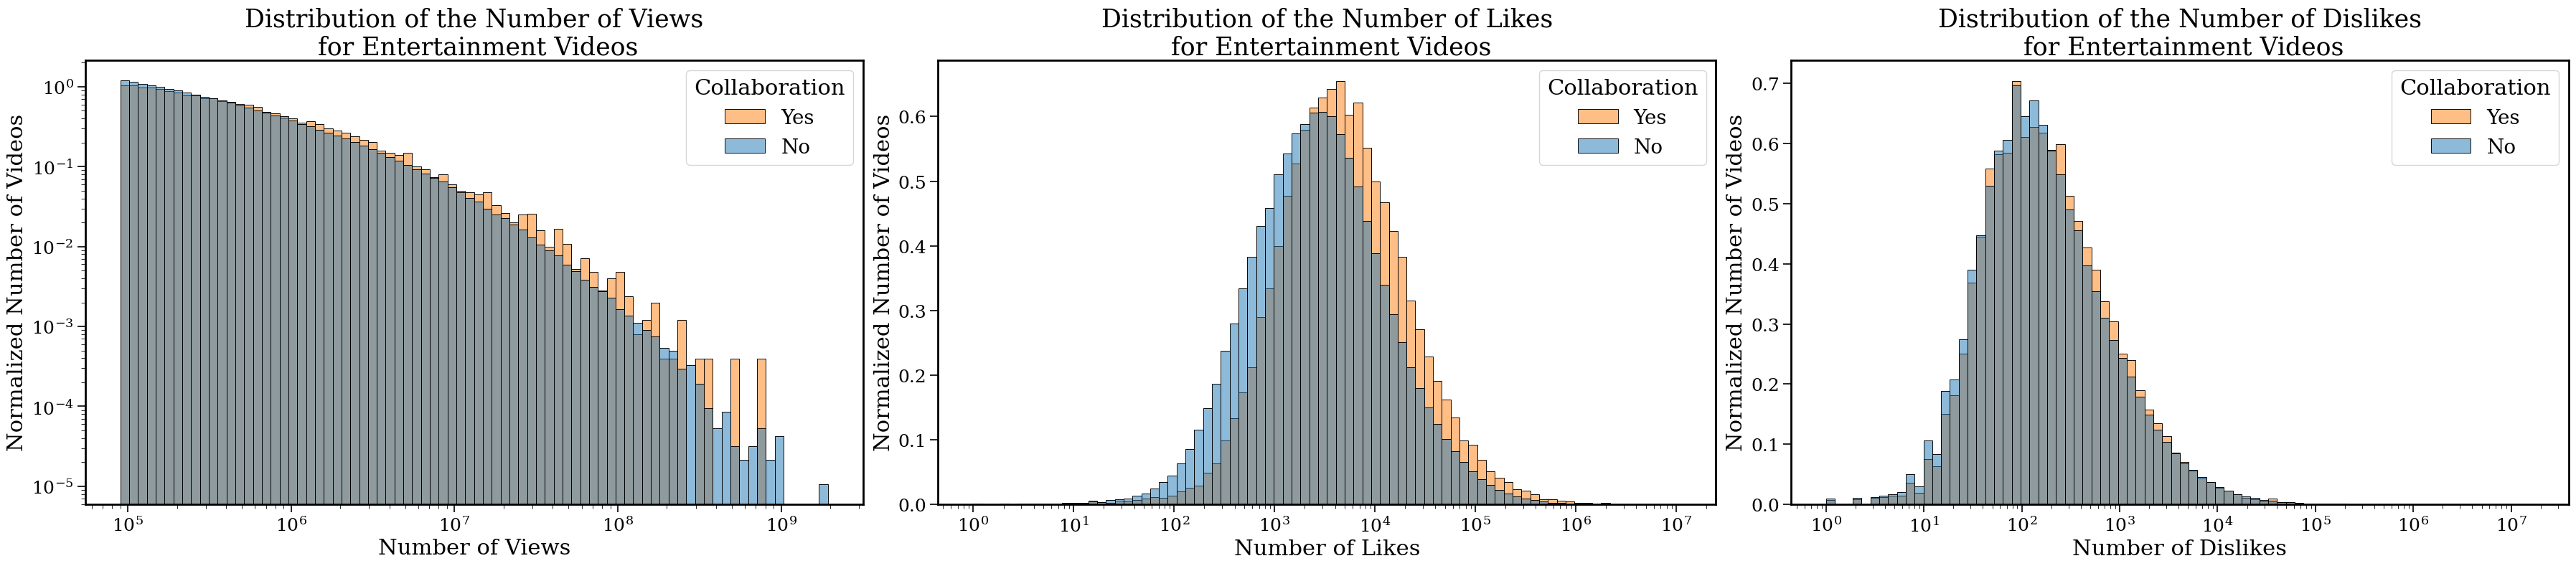

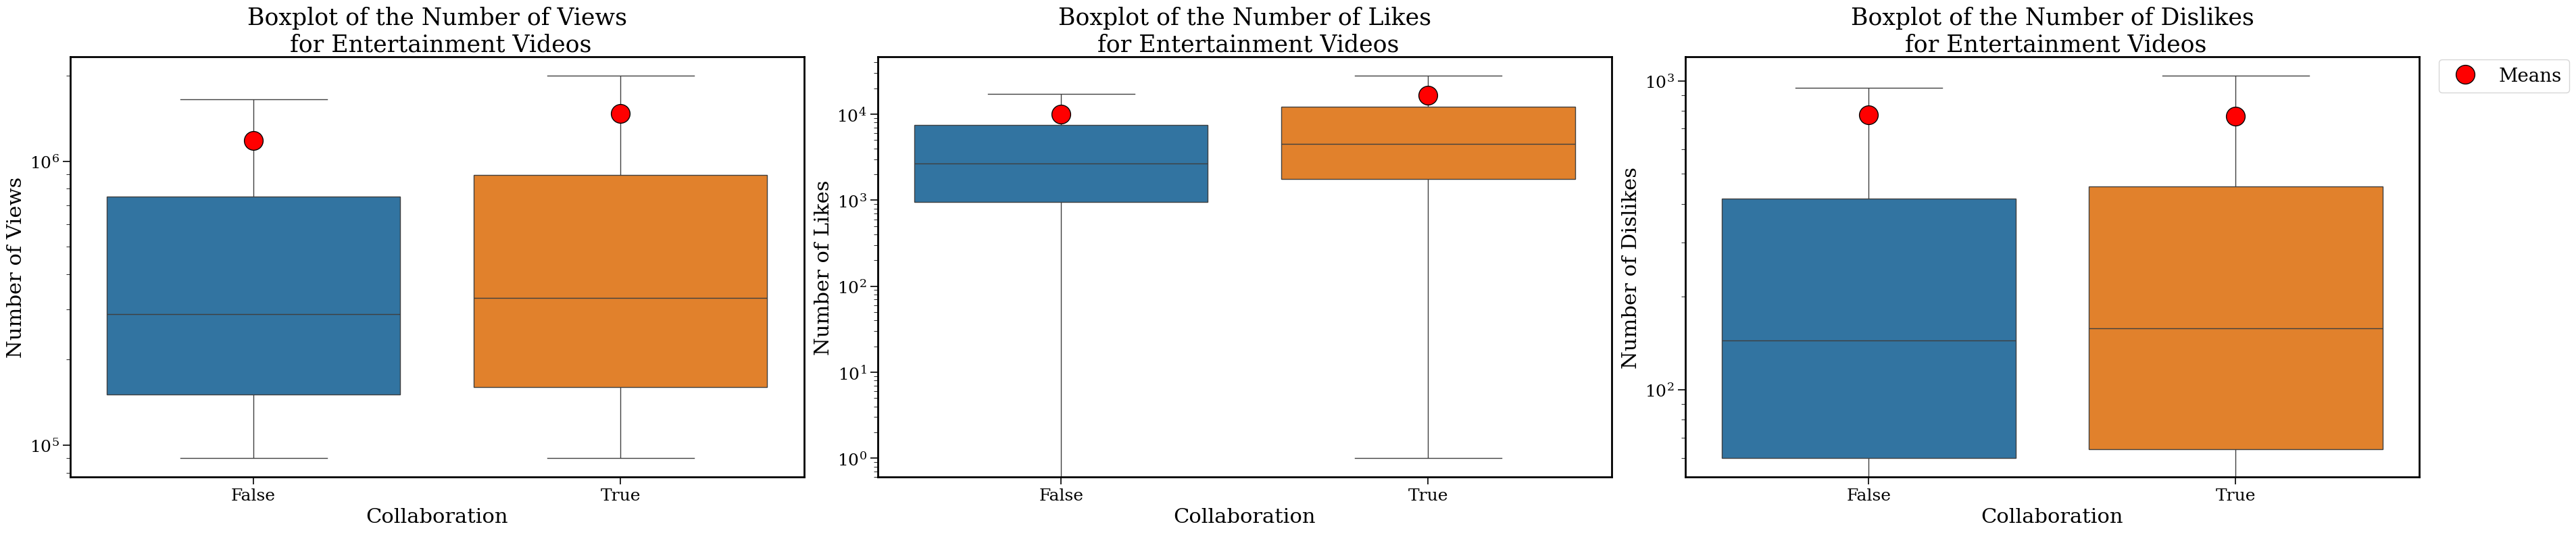

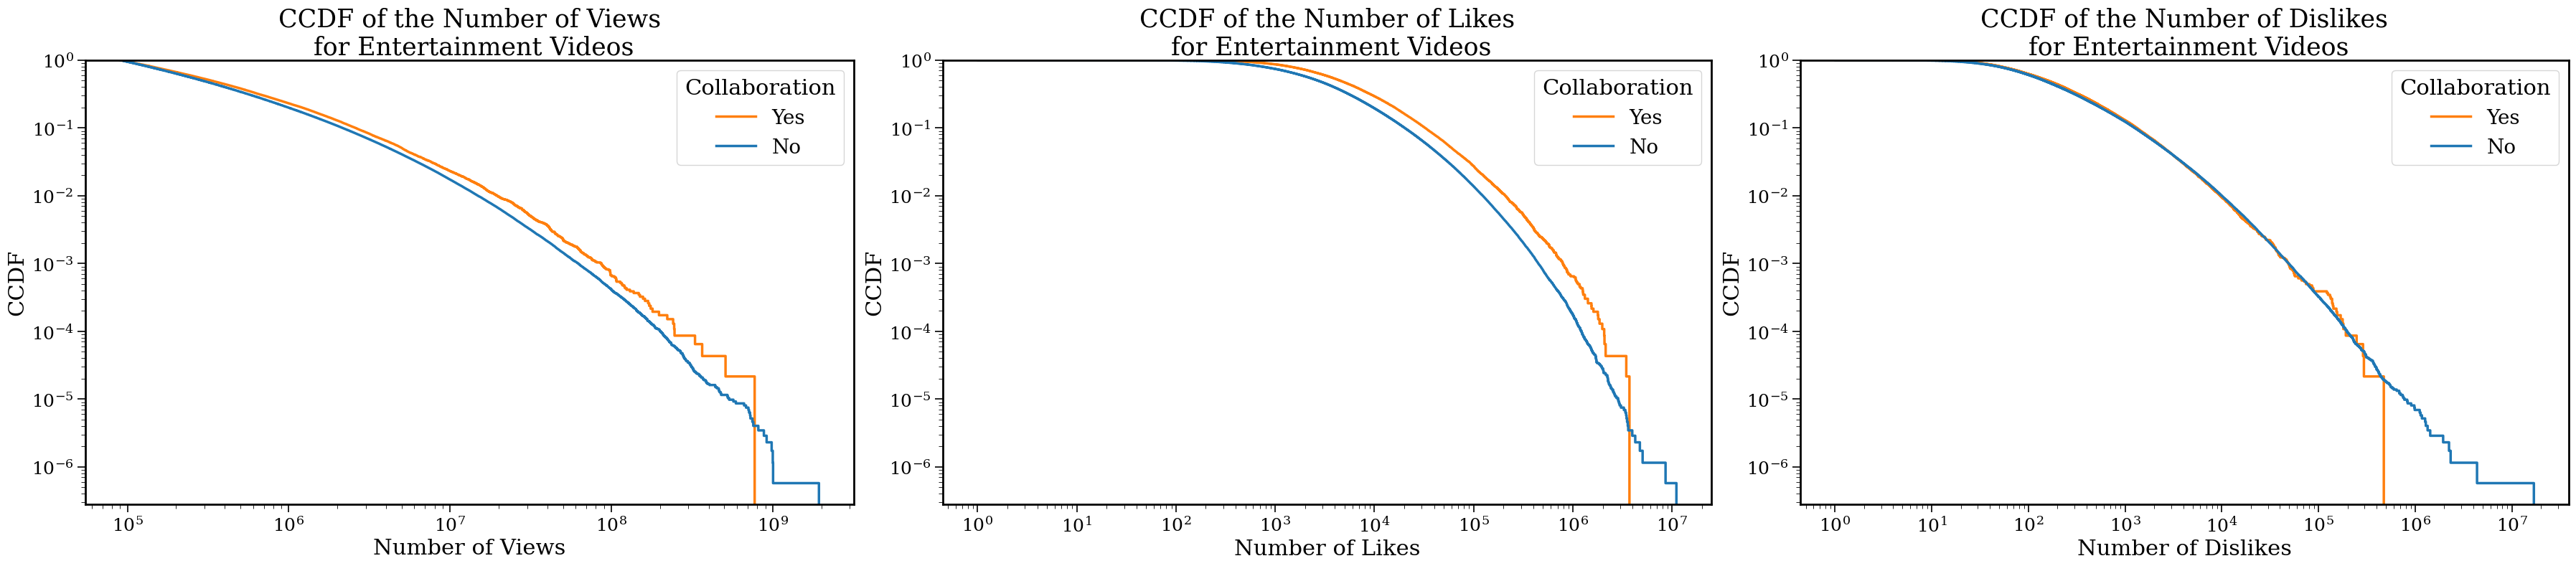

In [10]:
# Compare the different distributions between collaborations and non collaborations for the Entertainment category
collab_utils.plot_comparison_collab_and_non_collab(
    data=top_p_entertainment,
    category="Entertainment",
    columns=columns,
    x_logs=x_logs,
    y_logs=y_logs,
    custom_labels=custom_labels,
    save=True,
)

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Comments on the Figures:**
- **Views**: from the histogram, no clear difference can be observed between the two distributions, one can only notice that the tail of the distribution seems to be slightly heavier for collaborations. A more pronounced difference is noticeable on the boxplot: here the median and the upper percentiles are higher for collaborations. The mean is also higher for collaborations.

- **Likes** as for the Music category, the distributions seem to be close to log-normal. The histogram is slightly shifted toward higher like counts for collaborations. This is confirmed by the boxplot and CCDF, which show that the median and the upper percentiles are higher for collaborations. The mean is also higher for collaborations.

- **Dislikes**: Here the distributions are quite similar. Both the histogram and CCDF overlap significantly. The boxplot shows that the median and the upper percentiles are slightly higher for collaborations. The mean is almost the same in both cases.

</div>


In [11]:
collab_utils.compare_means_collab_non_collab(top_p_entertainment, columns, custom_labels)

╒═════════════════════════╤══════════════════╤══════════════════════╤════════════════╕
│ Metric                  │ Collaborations   │ Non-Collaborations   │   Ratio (C/NC) │
╞═════════════════════════╪══════════════════╪══════════════════════╪════════════════╡
│ Mean Number of Views    │ 1,471,830.73     │ 1,181,247.34         │           1.25 │
├─────────────────────────┼──────────────────┼──────────────────────┼────────────────┤
│ Mean Number of Likes    │ 16,580.74        │ 10,034.68            │           1.65 │
├─────────────────────────┼──────────────────┼──────────────────────┼────────────────┤
│ Mean Number of Dislikes │ 768.05           │ 774.44               │           0.99 │
╘═════════════════════════╧══════════════════╧══════════════════════╧════════════════╛


<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Comment on the table:**

The table shows the mean values for views, likes, and dislikes for collaboration and non-collaboration videos in the Entertainment category. It also displays the ratio between the two means. 

The results are less pronounced compared to the Music category. The mean values for views and likes are higher for collaborations by a factor of $1.25$ and $1.65$ respectively. The latter is almost the same as the one we got for the Music category. But, the mean dislikes is not significantly higher for collaborations. This suggests that while collaborations in the Entertainment category have a noticeable positive impact on views and likes, the effect is less pronounced compared to the Music category. The lack of a significant increase in dislikes for collaborations may indicate that the audience response to such videos is generally positive or neutral with little polarizing effect. 

</div>
  


In [12]:
collab_utils.test_distributions(top_p_entertainment, columns, custom_labels)

╒═════════════════════════════════════════╤═════════════╤═══════════╤════════════════╕
│ Test                                    │   Statistic │   P-Value │ Significant?   │
╞═════════════════════════════════════════╪═════════════╪═══════════╪════════════════╡
│ Mann-Whitney U (Number of Views)        │    4.24e+10 │  5.68e-90 │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Kolmogorov-Smirnov (Number of Views)    │    0.0422   │  3.34e-70 │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Cramér-von Mises (Number of Views)      │   40.12     │  0        │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Mann-Whitney U (Number of Likes)        │    4.85e+10 │  0        │ Yes            │
├─────────────────────────────────────────┼─────────────┼───────────┼────────────────┤
│ Kolmogorov-Smirnov (Number of Likes)    │

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Statistical Tests Results:**
As for the Music category, the $p$-values are all highly significant for the three metrics (views, likes, and dislikes) in the Entertainment category. This indicates that we should reject the null hypothesis that the distributions of views, likes, and dislikes are the same for collaboration and non-collaboration videos.

</div>


## Collaboration-Ratio Based Analysis

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

In this section, we start by computing the collaboration ratio of each channel. This ratio is defined as the number of collaborations divided by the total numer of videos of the channel. Then, we analyze the distribution of this ratio in different contexts.

</div>

In [13]:
# Create a file containing the number of collaborations for each channel
# process_collab_count(data_file='data/yt_metadata.jsonl.gz, output_path='data/collab_counts.jsonl.gz')

In [14]:
# Create a file containing the collaboration ratio of each channel
# collab_utils.process_collab_ratio(collab_count_filepath='data/collab_counts.jsonl.gz',
#                                   video_count_filepath='data/video_counts.jsonl.gz',
#                                   output_path='data/collab_ratio.jsonl.gz')

In [15]:
df_collab_ratio = pd.read_json("data/collab_ratio.jsonl.gz", lines=True, compression="gzip")

### Collaboration Ratio Distribution for channels that have at least one video in the top $p$ videos dataframe

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

Here, we analyze the distribution of the collaboration ratio for channels that contribute at least one video to the top 95% of total views. This is relevant as it allows us to compare the collaboration behaviour of channels across the two categories.

</div> 

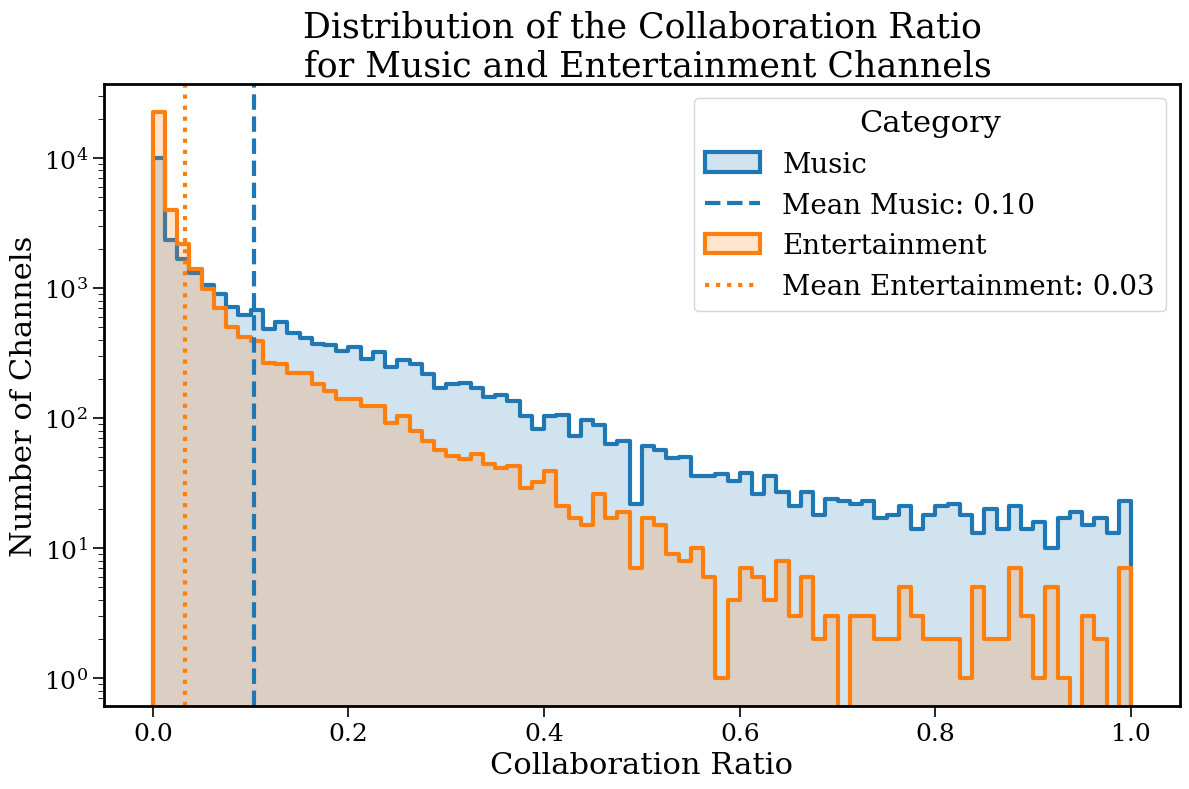

In [16]:
collab_utils.plot_collab_ratio_distribution(top_p_music, top_p_entertainment, df_collab_ratio, p=0.95, show_means=True,
                                            save=True, kind="hist")

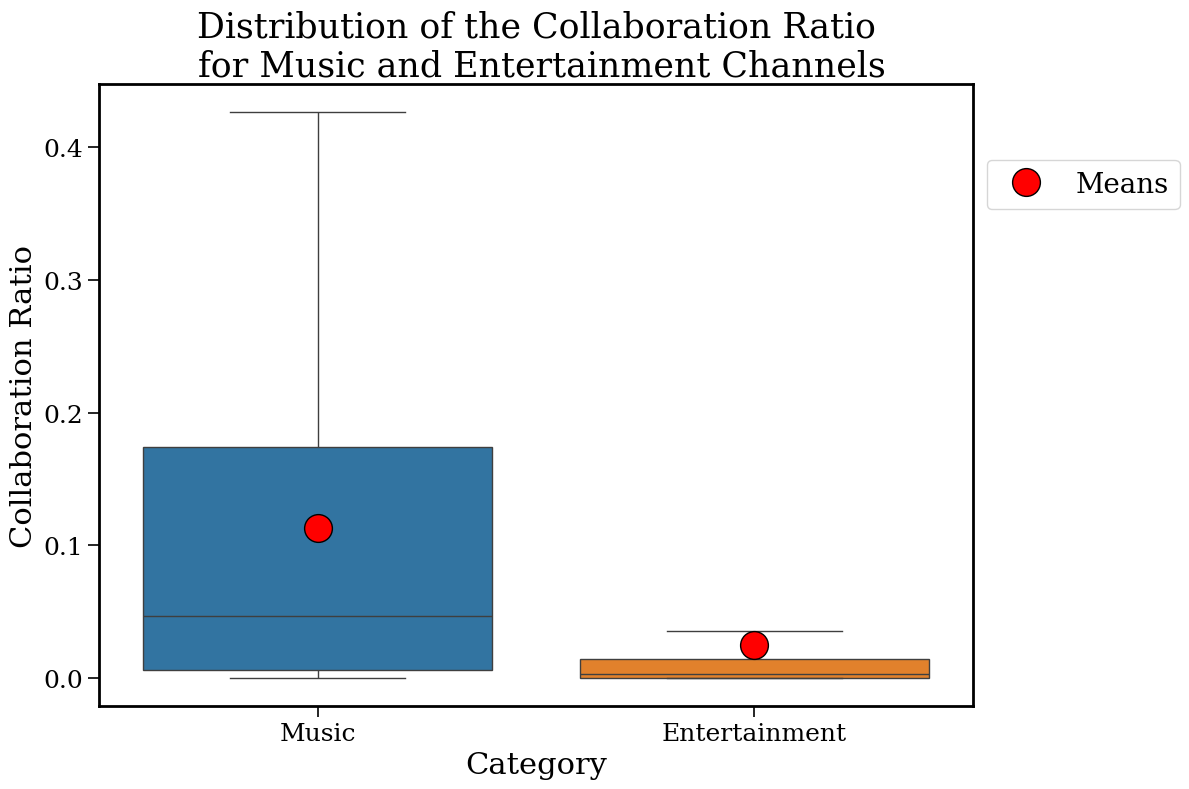

In [17]:
collab_utils.plot_collab_ratio_distribution(top_p_music, top_p_entertainment, df_collab_ratio, p=0.95, show_means=True,
                                            save=True, kind="boxplot")

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Comments on the Figures**: 

From the histogram, it is clear that the collaboration ratio distribution differs from one category to the other. There are more Music channels that often collaborate compared to Entertainment channels. This is confirmed by the boxplot, which shows that the median and the upper percentiles are higher for Music channels. The mean is also higher for Music channels.

</div>

#### Collaboration Ratio Distribution for Channels that Weight the Most and Comparison with other Channels

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

In this section, we adopt a different perspective by focusing on the relationship between collaboration behavior and channel popularity. For each category, we compare the collaboration ratio of the top channels in terms of subscribers (i.e., the channels that collectively account for a fraction $p$ of the total numbre of subscribers)with the remaining channels (which contribute to the remaining fraction $1-p$ of total subscribers).  This approach allows us to explore whether highly subscribed channels tend to engage more frequently in collaborations compared to less subscribed ones. This might reveal differences in terms of collaboration strategies between popular and less popular channels.

</div>

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

We start by loading the channels data and sorting the Music and Entertainment channels by their number of subscribers. We then keep the top $p$% and the bottom $(1-p)$% of channels based on the number of subscribers. 

</div>

In [24]:
# Load the channels data
df_channels = pd.read_csv("data/channels.tsv.gz", sep="\t", compression="gzip").rename(columns={'channel': 'channel_id'})

# Sort Music and Entertainment Channels by their subscriber count
df_music_channels = df_channels[df_channels["category_cc"] == "Music"].sort_values(by='subscribers_cc',ascending=False).reset_index(drop=True)
df_entertainment_channels = df_channels[df_channels["category_cc"] == "Entertainment"].sort_values(by='subscribers_cc',ascending=False).reset_index(drop=True)

In [25]:
# Keep the top p% and the bottom (1-p)% of channels based on the number of subscribers
p = 0.6

# Music
top_p_music_channels = collab_utils.filter_channels_by_proportion(df_music_channels, p_threshold=p)
bottom_p_music_channels = collab_utils.filter_channels_by_proportion(df_music_channels, p_threshold=p, top=False)

# Entertainment
top_p_entertainment_channels = collab_utils.filter_channels_by_proportion(df_entertainment_channels, p_threshold=p)
bottom_p_entertainment_channels = collab_utils.filter_channels_by_proportion(df_entertainment_channels, p_threshold=p, top=False)

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

We can print the results of the filtering step.

</div>

In [26]:
collab_utils.print_top_channels_stats(df_music_channels, df_entertainment_channels, top_p_music_channels, 
                                      top_p_entertainment_channels, bottom_p_music_channels, bottom_p_entertainment_channels, p)

Results for p = 0.6:

╒═══════════════╤═══════════════════════════════╤════════════════╤═══════════════════╤════════════════╤═══════════════════╕
│ Category      │   Original Number of Channels │   Top Channels │   Bottom Channels │ Top Fraction   │ Bottom Fraction   │
╞═══════════════╪═══════════════════════════════╪════════════════╪═══════════════════╪════════════════╪═══════════════════╡
│ Music         │                         29166 │            984 │             28182 │ 3.37%          │ 96.63%            │
├───────────────┼───────────────────────────────┼────────────────┼───────────────────┼────────────────┼───────────────────┤
│ Entertainment │                         26347 │           1363 │             24984 │ 5.17%          │ 94.83%            │
╘═══════════════╧═══════════════════════════════╧════════════════╧═══════════════════╧════════════════╧═══════════════════╛


Top 60.00%

╒═══════════════╤═════════════════════════════╤══════════════╤════════════╕
│ Category      │   Original Number of Videos │   Top Videos │ Fraction   │
╞═══════════════╪═════════════════════════════╪══════════════╪════════════╡
│ Music         │                       29166 │          984 │ 3.37%      │
├───────────────┼─────────────────────────────┼──────────────┼────────────┤
│ Entertainment │                       26347 │         1363 │ 5.17%      │
╘═══════════════╧═════════════════════════════╧══════════════╧════════════╛


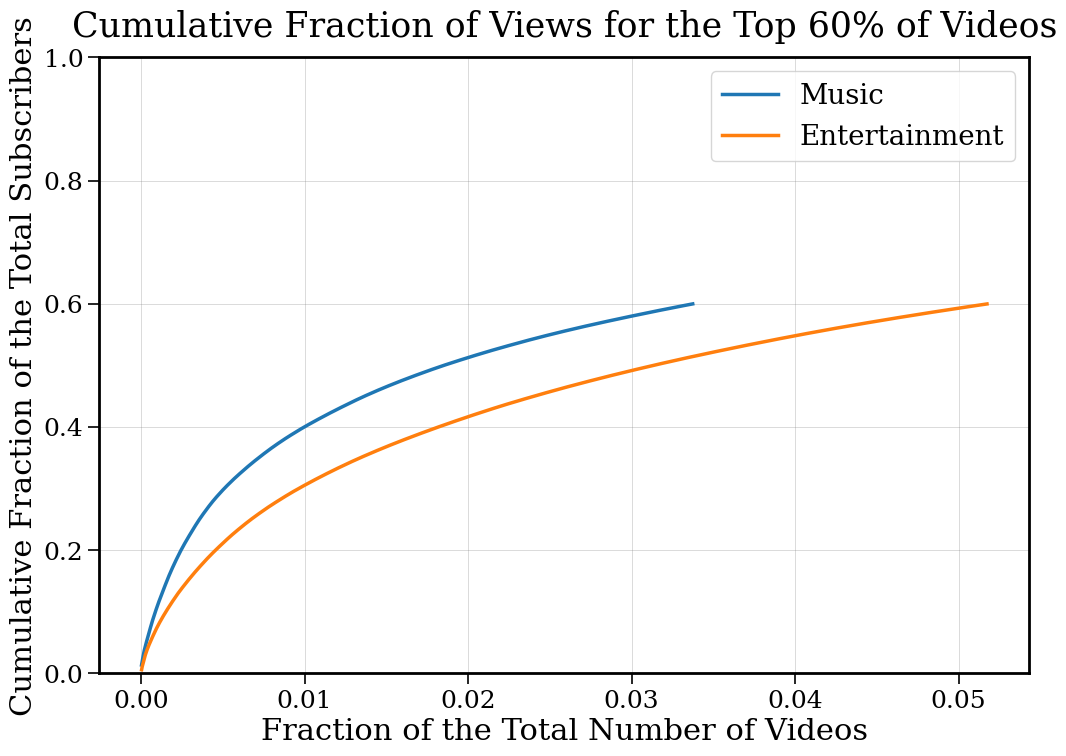

In [27]:
collab_utils.top_p_results(df_music_channels, top_p_music_channels, df_entertainment_channels, top_p_entertainment_channels, p, plot=True, kind="subscriber_count")

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Comments on the Results:**

The table shows that for $p=0.6$, the top 60% of subscribers in the Music and Entertainment categories are concentrated in a small fraction of channels (3.37% for Music and 5.17% for Entertainment). These small proportions highlight a strong disparity where a minority of channels dominate the subscriber base.The vast majority of channels contribute to the remaining 40%.

The plot illustrates the cumulative fraction of subscribers for the top 60% of channels in the Music and Entertainment categories. As in the case of the fraction of the total views illustrated earlier, the curve for Music rises more sharply than for Entertainment. The difference is less significant than for views, but this suggests that the Music category exhibits a stronger "winner-takes-all" dynamic, where a smaller number of highly subscribed channels dominate the audience base. In contrast, the Entertainment category shows a slightly more distributed subscriber base, although it remains skewed. This pattern aligns with previous observations on view distribution and highlights the differing audience concentration dynamics between these two categories.

</div>

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

The following step consists of merging the collaboration ratio with the top $p$% of channels. We then compare the collaboration ratio between the top $p$% and the bottom $(1-p)$% of channels in both categories. 

This allows us to assess whether highly subscribed channels tend to collaborate more frequently compared to less subscribed ones.

</div>

In [28]:
# Merge the collaboration ration with the top p% of channels
top_p_music_channels = top_p_music_channels.merge(df_collab_ratio, on="channel_id", how="left").dropna()
bottom_p_music_channels = bottom_p_music_channels.merge(df_collab_ratio, on="channel_id", how="left").dropna()

top_p_entertainment_channels = top_p_entertainment_channels.merge(df_collab_ratio, on="channel_id", how="left").dropna()
bottom_p_entertainment_channels = bottom_p_entertainment_channels.merge(df_collab_ratio, on="channel_id", how="left").dropna()

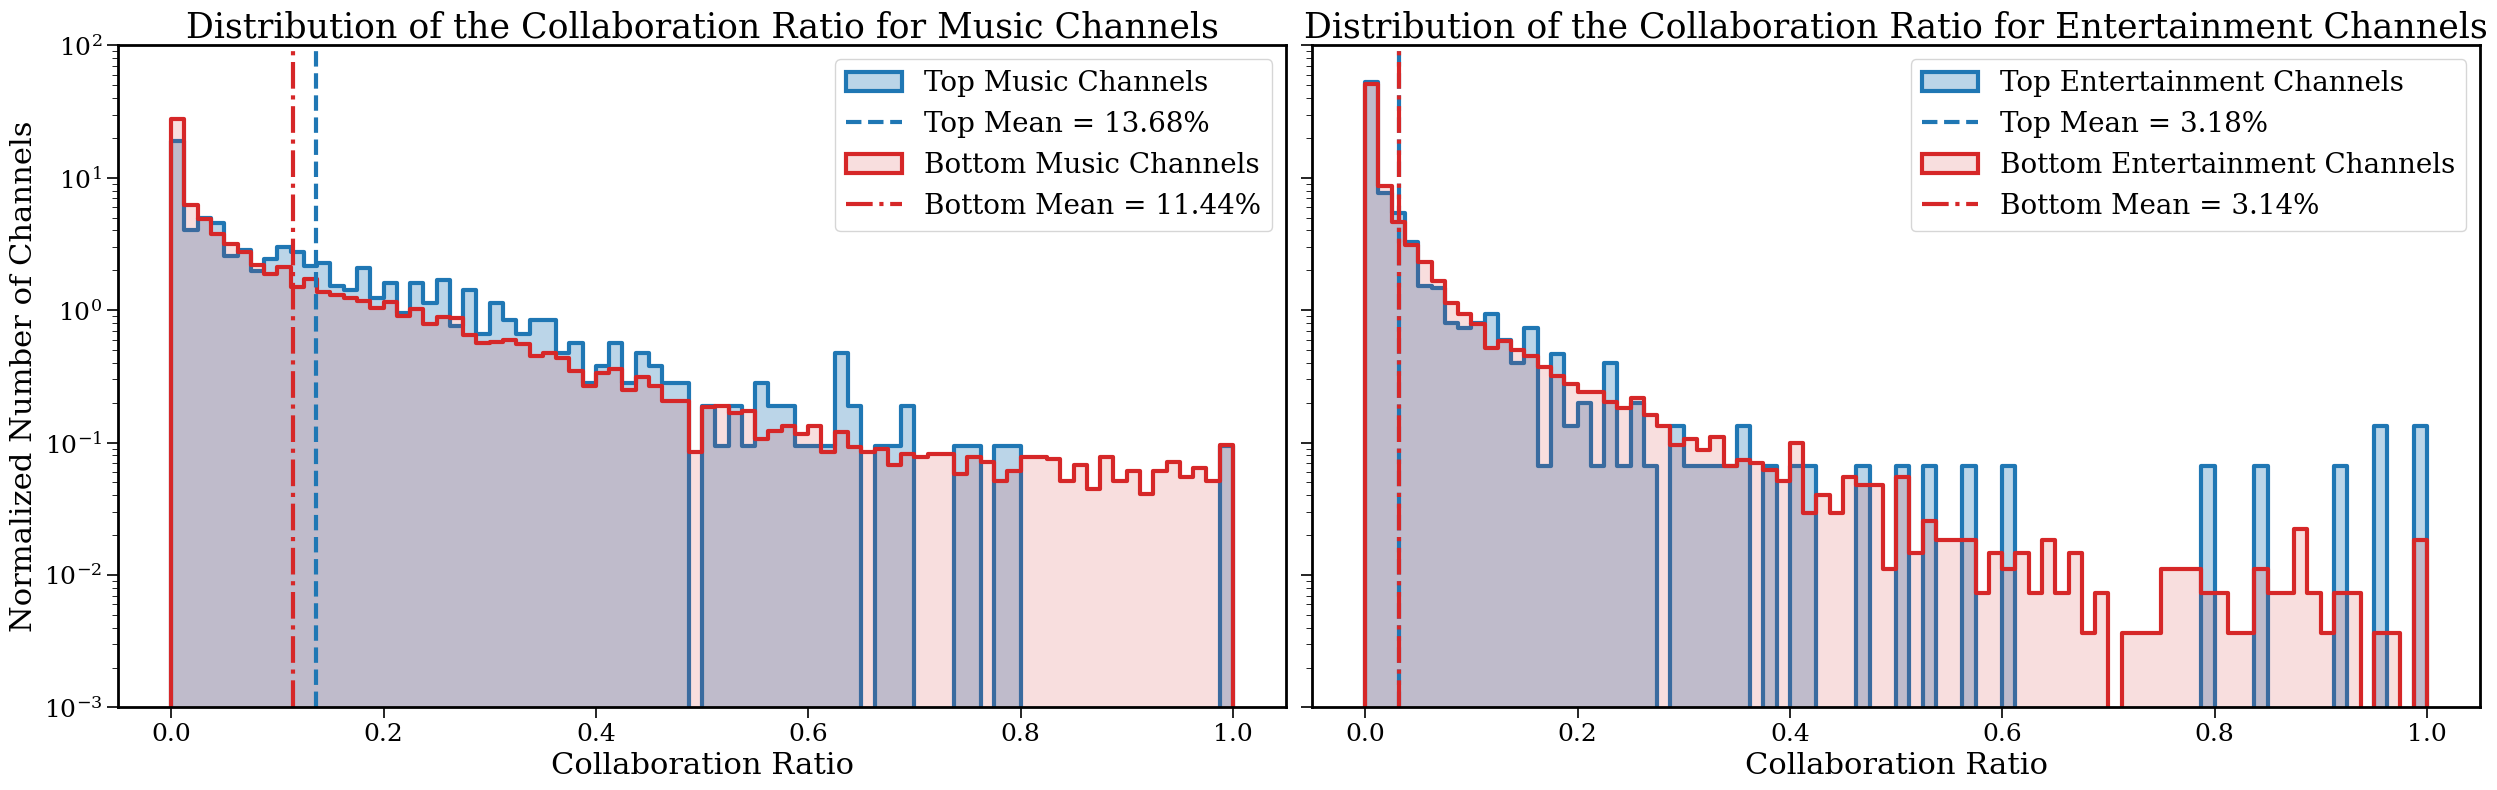

In [63]:
collab_utils.compare_collab_ratio_top_p_channels(
    top_p_music_channels=top_p_music_channels, 
    bottom_p_music_channels=bottom_p_music_channels,
    top_p_entertainment_channels=top_p_entertainment_channels,
    bottom_p_entertainment_channels=bottom_p_entertainment_channels,
    p=p, 
    save=True, 
    kind="hist"
)                                         

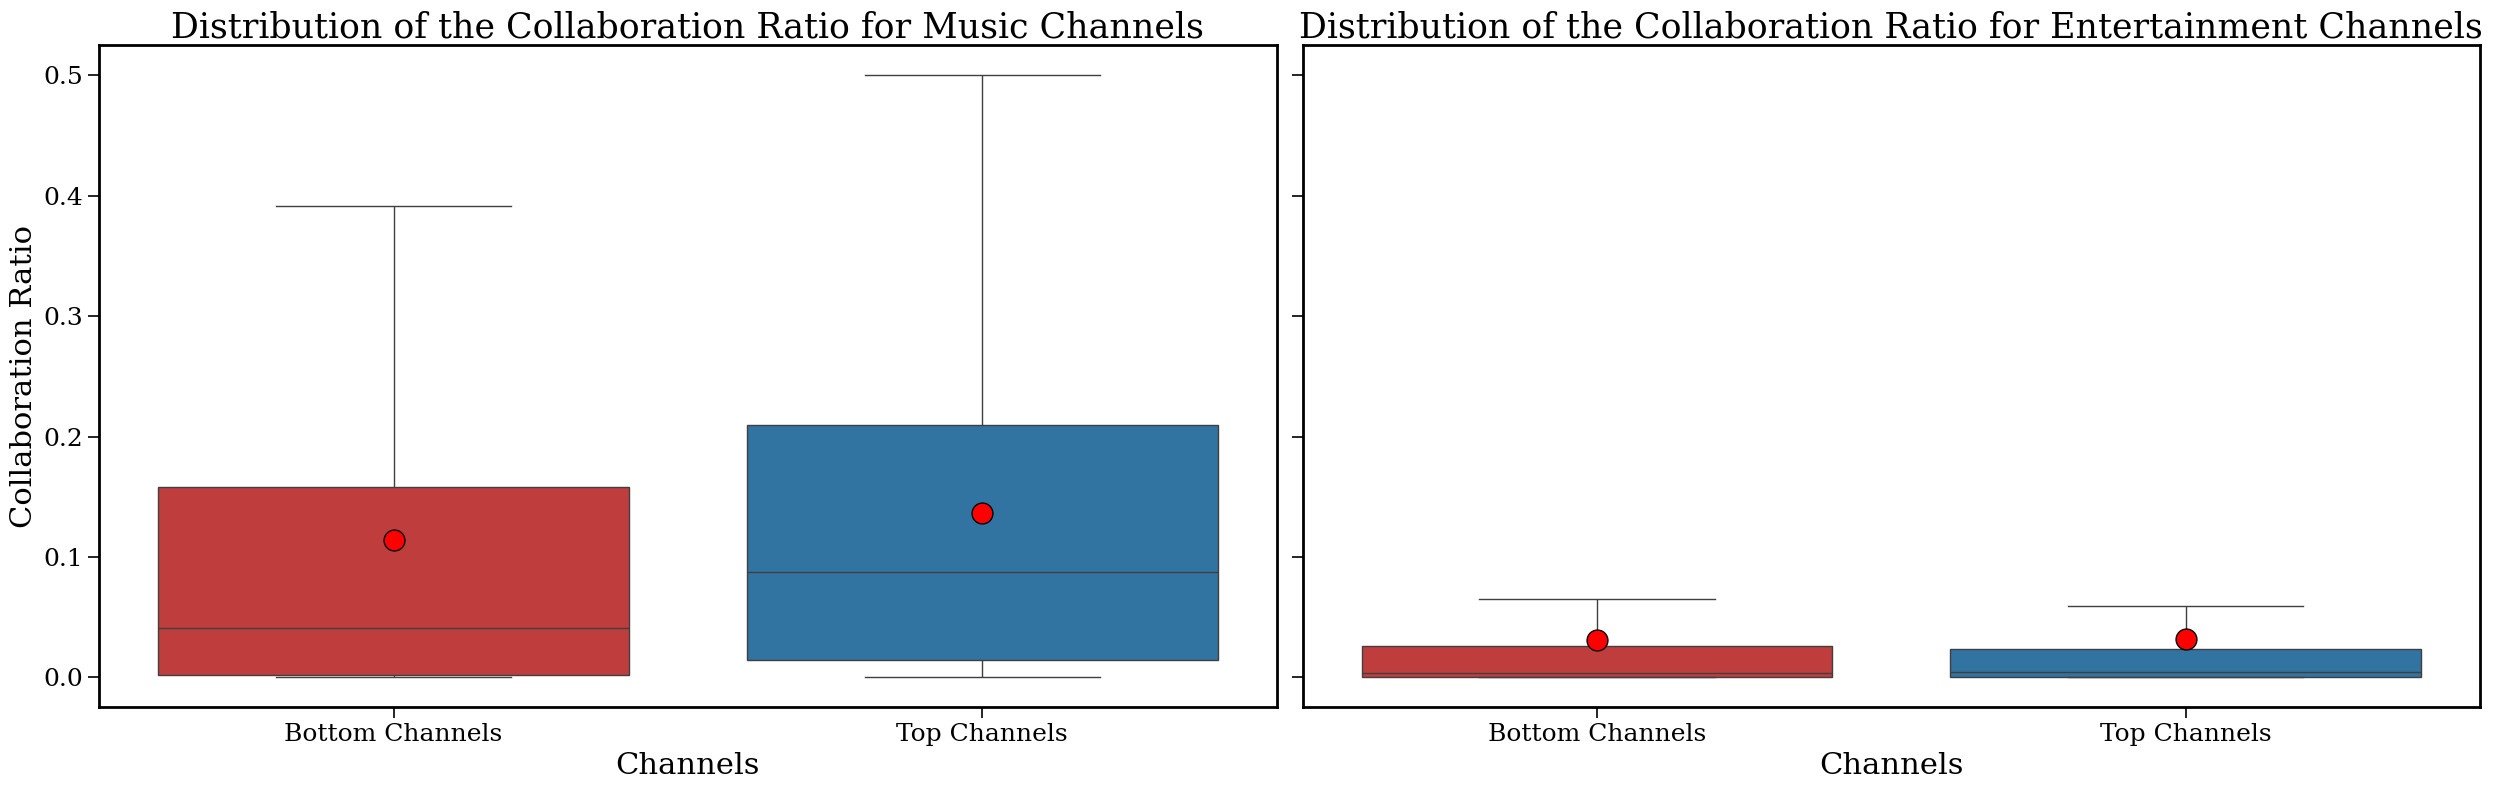

In [85]:
collab_utils.compare_collab_ratio_top_p_channels(
    top_p_music_channels=top_p_music_channels,
    bottom_p_music_channels=bottom_p_music_channels,
    top_p_entertainment_channels=top_p_entertainment_channels,
    bottom_p_entertainment_channels=bottom_p_entertainment_channels,
    p=p,
    save=True,
    kind="boxplot"
)

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Comments on the Figures:**

From left to right, the plots compare the distribution of the collaboration ratio between the top $p\%$ and the bottom $(1-p)\%$ of channels in the Music and Entertainment categories. The $y$-axis is shared across the plots to facilitate comparison.

**Music channels**: The shape of the distributions for top and bottom channels is similar. One can notice that within the Music top channels, there is an "empty" range between $0.8$ and $0.9875$. The mean collaboration ration depicted with dotted lines is higher for the more popular channels. The boxplot shows that the median and the upper percentiles are higher for the top channels. 

**Entertainment channels**: The shape of the distributions is again similar. There are more empty ranges than in the Music category. The plot bellow shows the same boxplots but this time the $y$-axis is not shared. This allows to better see the collaboration ratio distributions for the Entertainment channels. The medians almost align, as well as the mean (depicted with dotted lines in the histogramm). This shows that there is no clear collaboration strategy difference between the top and bottom channels in the Entertainment category.

</div>

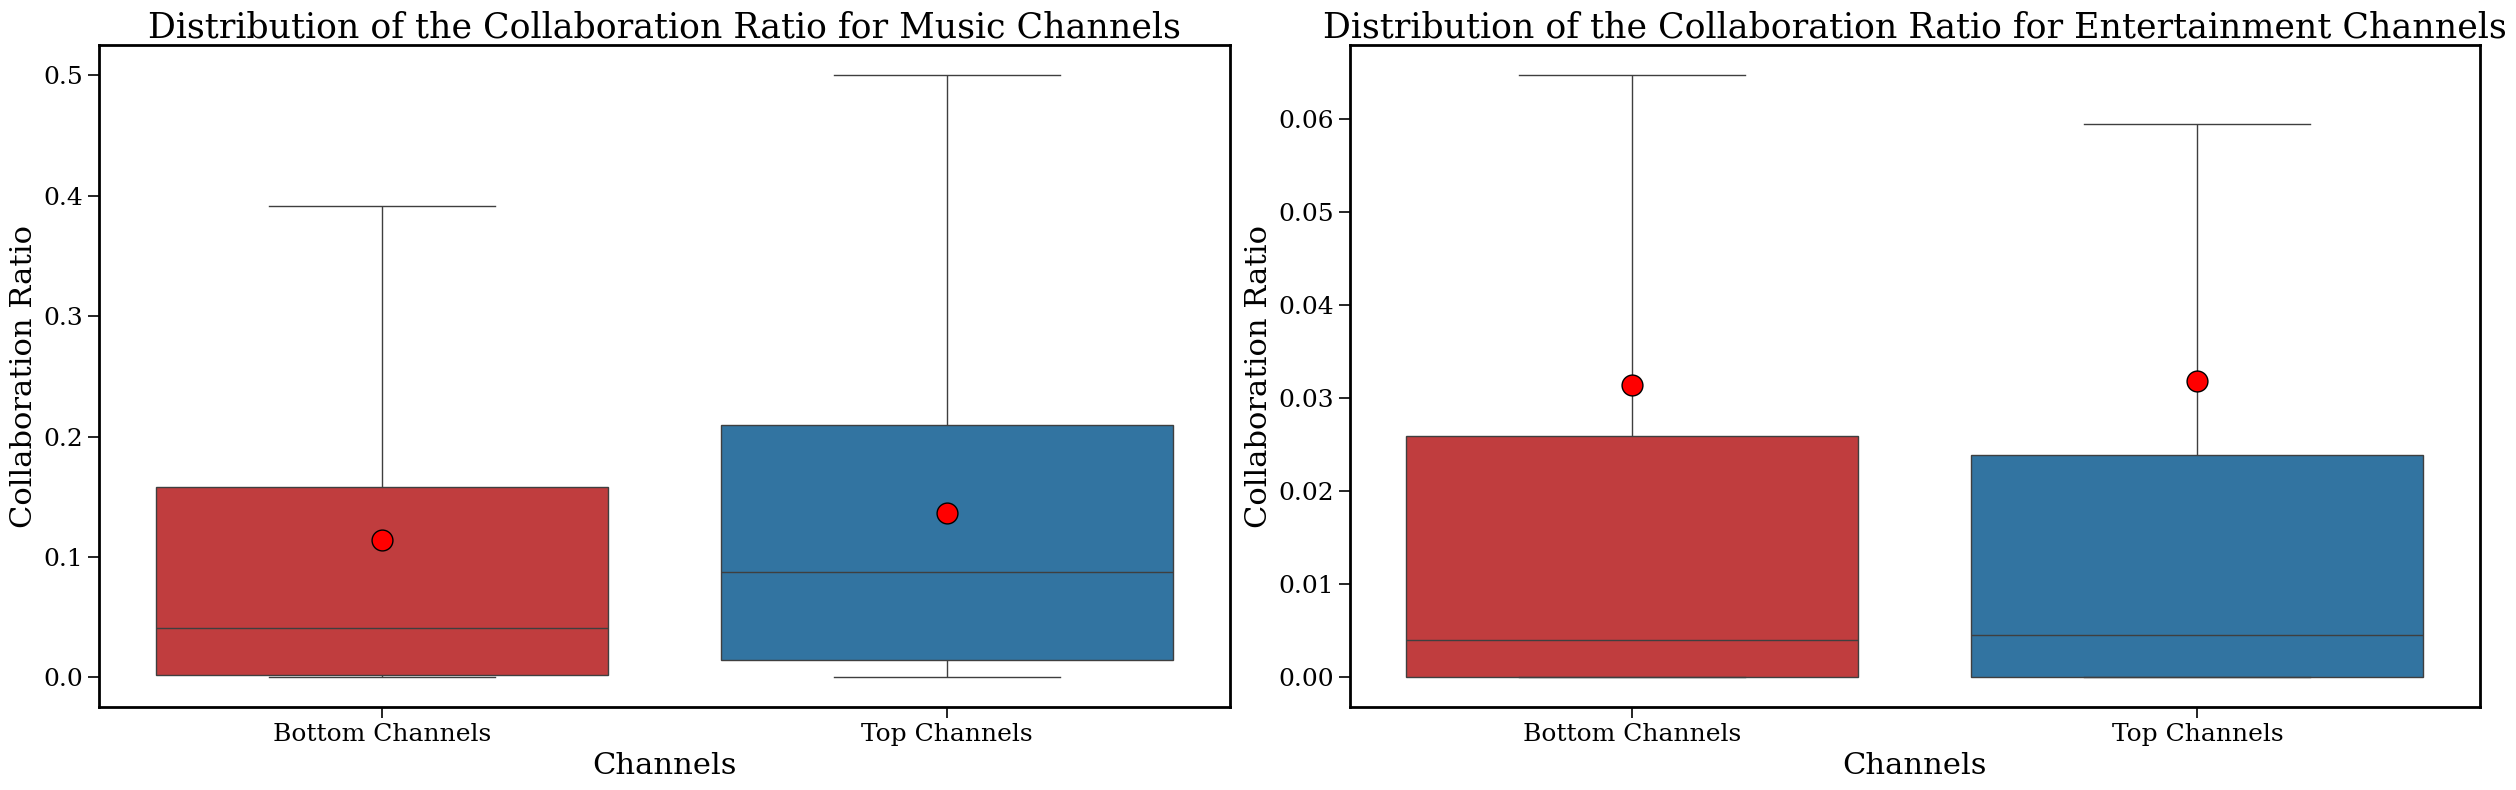

In [86]:
collab_utils.compare_collab_ratio_top_p_channels(
    top_p_music_channels=top_p_music_channels,
    bottom_p_music_channels=bottom_p_music_channels,
    top_p_entertainment_channels=top_p_entertainment_channels,
    bottom_p_entertainment_channels=bottom_p_entertainment_channels,
    p=p,
    save=True,
    kind="boxplot",
    sharey=False
)

In [64]:
collab_utils.test_distribution_top_vs_bottom(top_data=[top_p_music_channels, top_p_entertainment_channels], 
                                             bottom_data=[bottom_p_music_channels, bottom_p_entertainment_channels],
                                             categories=["Music", "Entertainment"],
                                             columns=["collab_ratio"])

╒═══════════════════════════════════╤═══════════════╤═════════════╤═══════════╤════════════════╕
│ Test                              │ Category      │   Statistic │   P-Value │ Significant?   │
╞═══════════════════════════════════╪═══════════════╪═════════════╪═══════════╪════════════════╡
│ Mann-Whitney U (collab_ratio)     │ Music         │    1.15e+07 │  8.48e-16 │ Yes            │
├───────────────────────────────────┼───────────────┼─────────────┼───────────┼────────────────┤
│ Kolmogorov-Smirnov (collab_ratio) │ Music         │    0.14     │  1.92e-14 │ Yes            │
├───────────────────────────────────┼───────────────┼─────────────┼───────────┼────────────────┤
│ Cramér-von Mises (collab_ratio)   │ Music         │  725        │  1.68e-07 │ Yes            │
├───────────────────────────────────┼───────────────┼─────────────┼───────────┼────────────────┤
│ Mann-Whitney U (collab_ratio)     │ Entertainment │    1.37e+07 │  0.00342  │ Yes            │
├─────────────────────────────

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Statistical Tests Results:** 

The table shows the results of the statistical tests comparing the distribution of the collaboration ratio between the top $p\%$ and the bottom $(1-p)\%$ of channels in the Music and Entertainment categories.

All the $p$ values are bellow a significance level of $0.05$. This indicates that we should reject the null hypothesis that the distribution of the collaboration ratio is the same between the top $p\%$ and the bottom $(1-p)\%$ of channels (based on subscribers count).

</div> 